In [1]:
import numpy as np
import pandas as pd
import gzip
import pickle
from collections import Counter
from utils import split_all_data
from scipy.stats import skew, kurtosis

import re
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
# if you dont have the model uncomment the line below
#!python -m spacy download en_core_web_lg

In [3]:
RANDOM_SEED = 1835

In [6]:
data_dict = split_all_data(.8, random_state=RANDOM_SEED)
train_df = data_dict['train']

Loading the data...
Splitting the data...


### Section 1 Tokenizer and Stemming functions

#### 1.1 Definitions

In [4]:
spacy_model = spacy.load('en_core_web_lg')

def spacy_tokenizer(text):
    sp_text = spacy_model(text)
    tokens = [token.lemma_ for token in sp_text if (not token.is_stop and token.is_alpha)]
    return tokens

In [5]:
stop_words = stopwords.words('english')

stemmer = PorterStemmer()
def stem_token(text):
    tokens = [stemmer.stem(word) for word in re.findall(r'\w\w+', text) if word not in stop_words]
    return tokens

#### 1.2 Speed Comparison

In [7]:
%%timeit
spacy_tokenizer(train_df['tweet'].iloc[10][0])

25.6 ms ± 4.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
stem_token(train_df['tweet'].iloc[10][0])

964 µs ± 81.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### 1.3 Output Comparison

In [9]:
# testing the tokenizer/lemmatizer
for item in train_df.sample(10, random_state=RANDOM_SEED).itertuples():
    if item[3] is not None:
        tokenized_s = stem_token(item[3][0])
        tokenized_l = spacy_tokenizer(item[3][0])
        count_stem = Counter(tokenized_s)
        count_lemm = Counter(tokenized_l)
        print(f'user: {item[1]} - label: {item[-1]}\n', 'Stemming:     ', count_stem.most_common(10), '\n', 'Lemmatization:', count_lemm.most_common(10), '\n')
    else:
        pass

user: 1290597237991575552 - label: 1
 Stemming:      [('no', 1), ('question', 1), ('de', 1), ('jong', 1), ('bloke', 1), ('worst', 1), ('striker', 1), ('ever', 1), ('seen', 1), ('life', 1)] 
 Lemmatization: [('question', 1), ('De', 1), ('Jong', 1), ('bloke', 1), ('bad', 1), ('striker', 1), ('see', 1), ('life', 1), ('score', 1), ('winner', 1)] 

user: 159535879 - label: 0
 Stemming:      [('rt', 1), ('sadwrit', 1), ('http', 1), ('co', 1), ('ibdvhk7ayt', 1)] 
 Lemmatization: [('RT', 1)] 

user: 22189352 - label: 0
 Stemming:      [('fire', 2), ('final', 1), ('no', 1), ('injuri', 1), ('ff', 1), ('civilian', 1), ('occup', 1), ('displac', 1), ('due', 1), ('caus', 1)] 
 Lemmatization: [('fire', 2), ('FINAL', 1), ('injury', 1), ('FF', 1), ('civilian', 1), ('occupant', 1), ('displace', 1), ('cause', 1), ('investigation', 1)] 

user: 2637583066 - label: 1
 Stemming:      [('5g06021008', 1), ('efiaodo1', 1), ('you', 1), ('right', 1), ('lol', 1), ('swear', 1)] 
 Lemmatization: [('right', 1), ('lol

### Section 2 Topic Extraction

#### 2.1 Definition

In [10]:
def extract_topic_feature(row, components=None, tokenizer=None, random_state=None):
    
    if row is not None:
        tweets = np.array(row)

        vectorize = TfidfVectorizer(tokenizer=tokenizer, 
                                    ngram_range=(1, 2),
                                    stop_words=None if tokenizer is not None else 'english',
                                    min_df=2,
                                    max_features=3000)
        try:
            vect_tweets = vectorize.fit_transform(tweets)
        except Exception:
            return np.nan
            
        print(vect_tweets.shape)
        if components is None:
            components = min(vect_tweets.shape)
            if components < 2:
                return np.nan
        elif components > min(vect_tweets.shape):
            components = min(vect_tweets.shape)
            if components < 2:
                return np.nan

        nmf_model = NMF(n_components=components, 
                        init='nndsvd', 
                        max_iter=200, 
                        random_state=random_state)
        
        try:
            W = nmf_model.fit_transform(vect_tweets)
        except ValueError as e:
            print(e)
            return np.nan
        
        index_max = []
        for index in range(W.shape[0]):
            max_val_index = np.argmax(W[index])
            index_max.append(max_val_index)
            
        index_norm = np.array(index_max) / components
        
        return index_norm
    else:
        return np.nan

In [11]:
# unweighted gini coefficient measure taken from https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python by user Gaëtan de Menten
def gini(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(sorted_x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

#### 2.2 Testing with different preprocessing

ID: 1290597237991575552 - Label 1 - number of tweets 17
(17, 15)
(17, 21)
(17, 9)


,only stopword removal,with stemming,with lemmatization
skewness,0.326791,0.159167,0.32896
kurtosis,-1.193163,-1.178777,-1.449917
standard deviation,0.196861,0.231343,0.252122
gini coefficient,0.47451,0.443228,0.546003


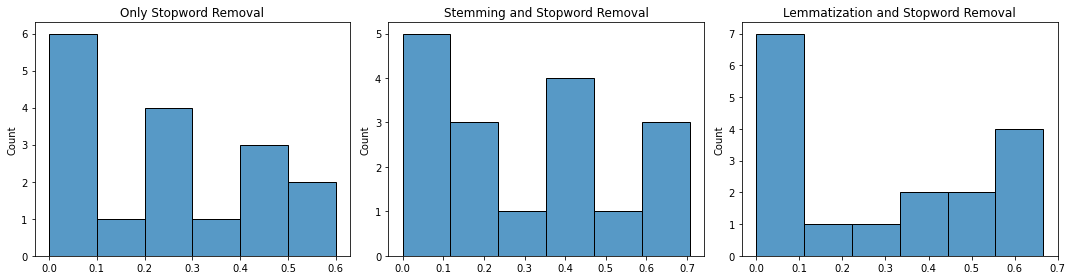

ID: 159535879 - Label 0 - number of tweets 194
(194, 273)
(194, 291)
(194, 283)


,only stopword removal,with stemming,with lemmatization
skewness,0.138261,-0.00147,0.179276
kurtosis,-1.467398,-1.434591,-1.378779
standard deviation,0.30613,0.303012,0.28753
gini coefficient,0.451416,0.419442,0.450835


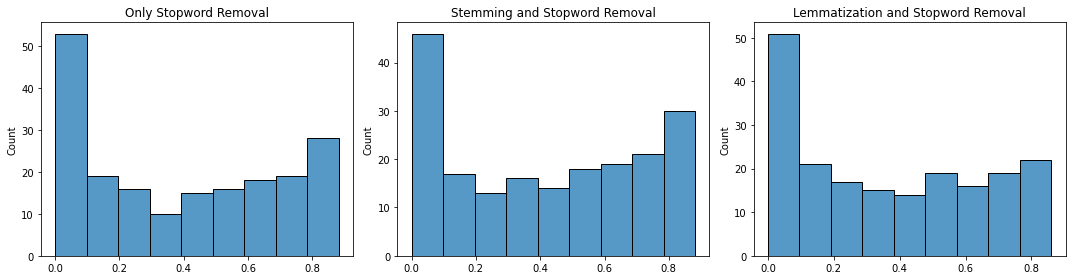

ID: 22189352 - Label 0 - number of tweets 200
(200, 863)
(200, 935)
(200, 806)


,only stopword removal,with stemming,with lemmatization
skewness,-0.029342,-0.207656,-0.017174
kurtosis,-1.261706,-1.334327,-1.209669
standard deviation,0.296591,0.317527,0.2906
gini coefficient,0.346832,0.328663,0.343154


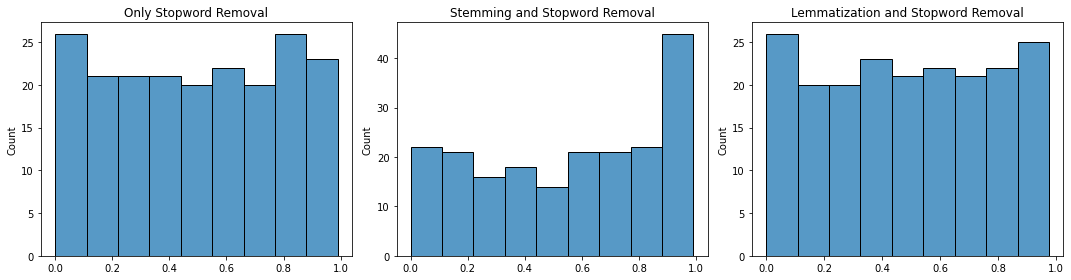

ID: 2637583066 - Label 1 - number of tweets 200
(200, 212)
(200, 228)
(200, 152)


,only stopword removal,with stemming,with lemmatization
skewness,0.217854,0.270507,0.664794
kurtosis,-1.415758,-1.306865,-0.975609
standard deviation,0.261645,0.26982,0.258526
gini coefficient,0.460829,0.456085,0.571356


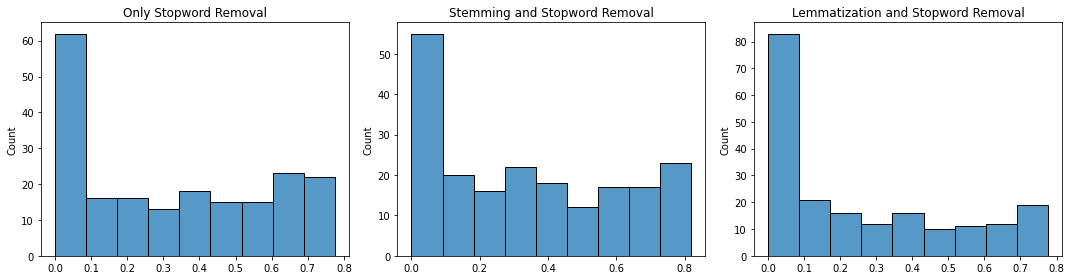

ID: 979469572494495744 - Label 0 - number of tweets 200
(200, 642)
(200, 678)
(200, 598)


,only stopword removal,with stemming,with lemmatization
skewness,-0.170138,-0.196188,0.109939
kurtosis,-1.267489,-1.319118,-1.413266
standard deviation,0.306642,0.31328,0.297228
gini coefficient,0.345475,0.353204,0.424658


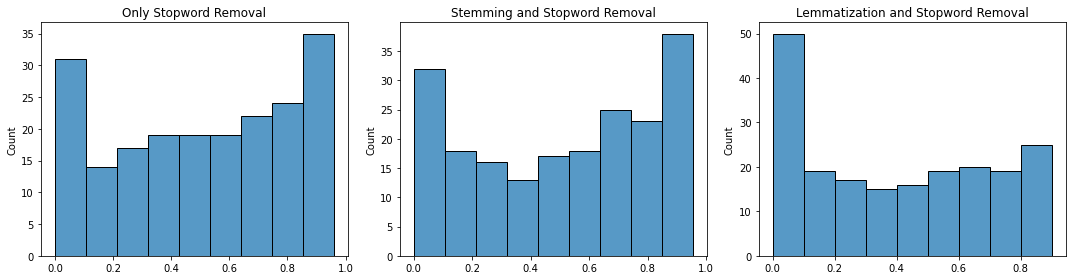

In [12]:


for row in train_df.sample(5, random_state=RANDOM_SEED).itertuples():
    print(f"ID: {row[1]} - Label {row[-1]} - number of tweets {len(row[3])}")
    ind0 = extract_topic_feature(row[3])
    ind1 = extract_topic_feature(row[3], tokenizer=stem_token)
    ind2 = extract_topic_feature(row[3], tokenizer=spacy_tokenizer)

    temp_df = pd.DataFrame(index=['skewness', 'kurtosis', 'standard deviation', 'gini coefficient'], columns=['only stopword removal', 'with stemming', 'with lemmatization'])

    temp_df.loc['skewness', 'only stopword removal'] = skew(ind0)
    temp_df.loc['skewness', 'with stemming'] = skew(ind1)
    temp_df.loc['skewness', 'with lemmatization'] = skew(ind2)
    

    temp_df.loc['kurtosis', 'only stopword removal'] = kurtosis(ind0)
    temp_df.loc['kurtosis', 'with stemming'] = kurtosis(ind1)
    temp_df.loc['kurtosis', 'with lemmatization'] = kurtosis(ind2)

    temp_df.loc['standard deviation', 'only stopword removal'] = ind0.std()
    temp_df.loc['standard deviation', 'with stemming'] = ind1.std()
    temp_df.loc['standard deviation', 'with lemmatization'] = ind2.std()

    temp_df.loc['gini coefficient', 'only stopword removal'] = gini(ind0)
    temp_df.loc['gini coefficient', 'with stemming'] = gini(ind1)
    temp_df.loc['gini coefficient', 'with lemmatization'] = gini(ind2)
    
    display(temp_df)

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    
    sns.histplot(ind0, ax=ax[0])
    ax[0].set_title('Only Stopword Removal')
    sns.histplot(ind1, ax=ax[1])
    ax[1].set_title('Stemming and Stopword Removal')
    sns.histplot(ind2, ax=ax[2])
    ax[2].set_title('Lemmatization and Stopword Removal')


    plt.tight_layout()
    plt.show()

In [13]:
def extract_nmf_feature(df, tokenizer=spacy_tokenizer):
    df.loc[:, 'topic_dist'] = df['tweet'].apply(lambda x: extract_topic_feature(x, tokenizer=tokenizer) if x is not None else np.nan)
    df.loc[:, 'topic_skew'] = df['topic_dist'].apply(lambda x: skew(x) if x is not None else np.nan)
    df.loc[:, 'topic_kurtosis'] = df['topic_dist'].apply(lambda x: kurtosis(x) if x is not None else np.nan)
    df.loc[:, 'topic_gini'] = df['topic_dist'].apply(lambda x: gini(x) if (x is not None) and (len(x) > 0) else np.nan)
    df.loc[:, 'topic_std'] = df['topic_dist'].apply(lambda x: np.array(x).std() if x is not None else np.nan)
    return df

In [14]:
%%time
with_topic_feat = extract_nmf_feature(train_df.sample(10, random_state=RANDOM_SEED))

(17, 9)
(194, 283)
(200, 806)
(200, 152)
(200, 598)
(197, 192)
(144, 210)
(184, 126)
(200, 347)
(200, 1318)
Wall time: 1min 10s


In [15]:
with_topic_feat[['topic_dist', 'topic_skew', 'topic_kurtosis', 'topic_gini', 'topic_std', 'label']]

,topic_dist,topic_skew,topic_kurtosis,topic_gini,topic_std,label
10139,"[0.0, 0.0, 0.4444444444444444, 0.6666666666666...",0.328960,-1.449917,0.546003,0.252122,1
4587,"[0.0, 0.36082474226804123, 0.04123711340206185...",0.179276,-1.378779,0.450835,0.287530,0
11274,"[0.4, 0.845, 0.275, 0.7, 0.43, 0.87, 0.63, 0.3...",-0.017174,-1.209669,0.343154,0.290600,0
1244,"[0.16447368421052633, 0.006578947368421052, 0....",0.664794,-0.975609,0.571356,0.258526,1
3949,"[0.78, 0.055, 0.79, 0.74, 0.575, 0.41, 0.465, ...",0.109939,-1.413266,0.424658,0.297228,0
7742,"[0.7552083333333334, 0.6927083333333334, 0.593...",0.204749,-1.407951,0.472705,0.273459,0
2018,"[0.4930555555555556, 0.20833333333333334, 0.21...",0.028777,-1.357506,0.398836,0.281260,1
2682,"[0.8571428571428571, 0.0, 0.0, 0.6349206349206...",0.417498,-1.386702,0.533920,0.317168,0
9994,"[0.085, 0.3, 0.615, 0.53, 0.19, 0.0, 0.37, 0.4...",0.114007,-1.298732,0.401189,0.286928,1
10884,"[0.445, 0.445, 0.47, 0.47, 0.47, 0.785, 0.47, ...",0.061169,-0.432280,0.291581,0.243930,0
